# Monte Carlo integration

## Theoretical aspects

The Monte Carlo integration method is based on the idea that an integral can be approximated by computing the mean value of the function evaluated at $N$ randomly sampled points, uniformly distributed over the integration domain.

$$
\int_a^b\,dx\, f(x) = \frac{b - a}{N}\sum_{i=1}^Nf(x_i)
$$

## Sampling generation

If we want to use the classical version of the MonteCarlo integration in order to calculate the integral: 

$$
\int_0^\infty \, dx\, x^3 e^{-\frac{x^2}{2\sigma^2}} = 2 \sigma^4
$$

We have to find a way to reduce the domain integration from $(0, \infty)$ to a finite one. 

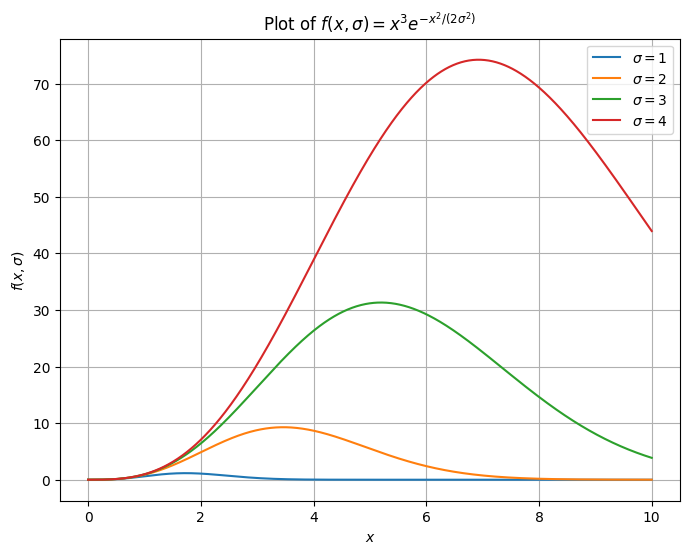

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def f(x, sigma):
    return x**3 * np.exp(-x**2 / (2 * sigma**2))

x = np.linspace(0, 10, 1000)  
sigmas = [1, 2, 3, 4]

plt.figure(figsize=(8, 6))
for sigma in sigmas:
    plt.plot(x, f(x, sigma), label=rf"$\sigma = {sigma}$")
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x, \sigma)$")
plt.title(r"Plot of $f(x, \sigma) = x^3 e^{-x^2 / (2\sigma^2)}$")
plt.legend()
plt.grid()
plt.show()

We observe that the function asymptotically approaches 0 for large $x$. To optimize the integration, we can set a threshold (e.g. $10^{-4}$) and consider that when the function goes under this limit, the contribution to the integral becomes negligible. 
In this way we can define a finite domain to aply the Monte Carlo algorithm. 

To find the zero we use the Newton-Raphson algorithm.

In [2]:
from scipy.optimize import newton
import random

# Compute derivative of f(x, sigma)
def df_dx(x, sigma):
    return (3*x**2 - x**4 / sigma**2) * np.exp(-x**2 / (2 * sigma**2))

# Function to find x where |f(x, sigma)| < threshold using Newton-Raphson
def find_threshold_x(sigma, x0=1.0, threshold=1e-4):
    def target_function(x):
        return f(x, sigma) - threshold

    try:
        x_threshold = newton(target_function, x0, fprime=lambda x: df_dx(x, sigma))
        return x_threshold
    except RuntimeError:
        return None  # If Newton's method fails to converge

def MonteCarlo_integration(function, min, max, N=10000): 
    x_samples = np.random.uniform(min, max, N)  # Generate random x values
    y_samples = function(x_samples)  # Evaluate function at sampled points

    return np.mean(y_samples) * (max - min)

sigmas = []
extremes = []
x0 = 1
for sigma in range(1, 100, 1): 
    max = find_threshold_x(sigma, x0)
    while max == None or  max < 1:
        x0 += 1
        max = find_threshold_x(sigma, x0)
    sigmas.append(sigma)
    extremes.append(max)

/tmp/ipykernel_11831/3404562399.py:5: RuntimeWarning: overflow encountered in scalar power
  return x**3 * np.exp(-x**2 / (2 * sigma**2))
/tmp/ipykernel_11831/3404562399.py:5: RuntimeWarning: invalid value encountered in scalar multiply
  return x**3 * np.exp(-x**2 / (2 * sigma**2))
/tmp/ipykernel_11831/1985826676.py:6: RuntimeWarning: overflow encountered in scalar power
  return (3*x**2 - x**4 / sigma**2) * np.exp(-x**2 / (2 * sigma**2))
/tmp/ipykernel_11831/1985826676.py:6: RuntimeWarning: invalid value encountered in scalar subtract
  return (3*x**2 - x**4 / sigma**2) * np.exp(-x**2 / (2 * sigma**2))
/tmp/ipykernel_11831/1985826676.py:6: RuntimeWarning: invalid value encountered in scalar multiply
  return (3*x**2 - x**4 / sigma**2) * np.exp(-x**2 / (2 * sigma**2))


### Plot the results

#### Residue vs sigma

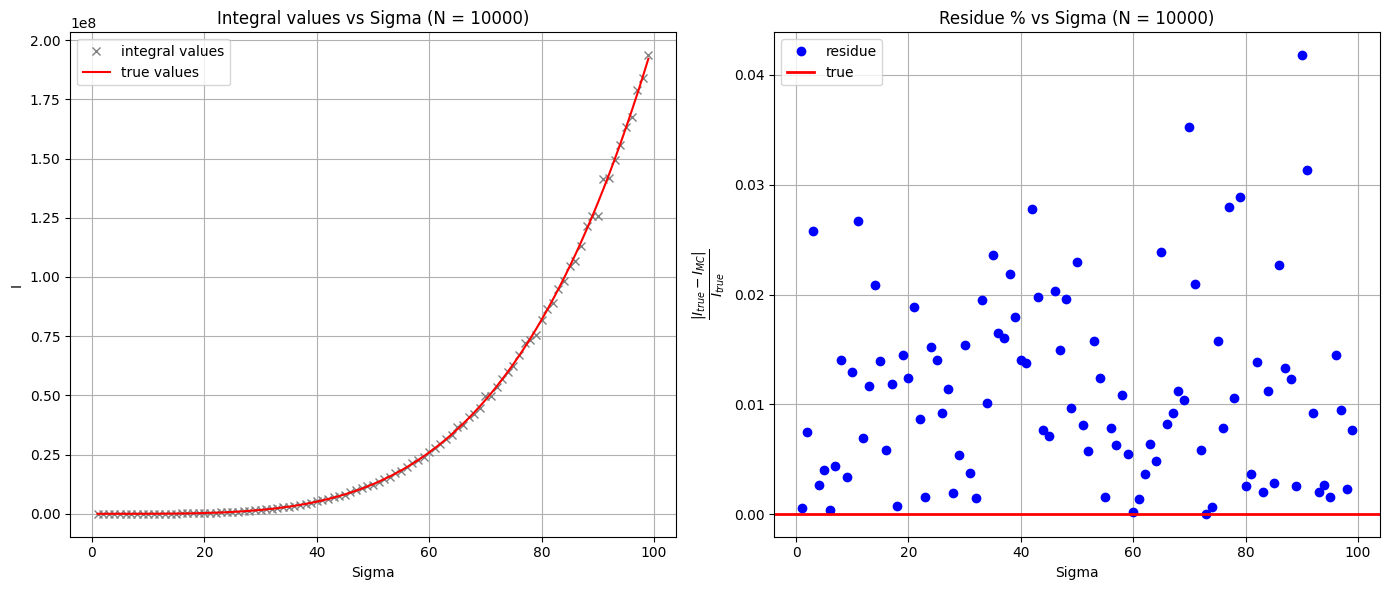

In [3]:
integral_values = []
true_values = []
residue = []
for sigma, max in zip(sigmas, extremes):
    f_lambda = lambda x: f(x, sigma)
    integral_value = MonteCarlo_integration(f_lambda, 0, max)

    true_value = 2 * sigma ** 4
    integral_values.append(integral_value)
    true_values.append(true_value)
    residue.append(np.abs(true_value - integral_value)/true_value)

# Plot results
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].plot(sigmas, integral_values, "x", label="integral values", color="gray")
axs[0].plot(sigmas, true_values, label="true values", color="red")
axs[0].set_xlabel("Sigma")
axs[0].set_ylabel("I")
axs[0].set_title("Integral values vs Sigma (N = 10000)")
axs[0].legend()
axs[0].grid()

axs[1].plot(sigmas, residue, "o", label="residue", color="blue")
axs[1].axhline(0, color='red', linewidth=2, label='true')
axs[1].set_xlabel("Sigma")
axs[1].set_ylabel(r"$\frac{|I_{true} - I_{MC}|}{I_{true}}$", size=14)
axs[1].set_title("Residue % vs Sigma (N = 10000)")
axs[1].legend()
axs[1].grid()

plt.tight_layout()
plt.show()

#### Reside vs N

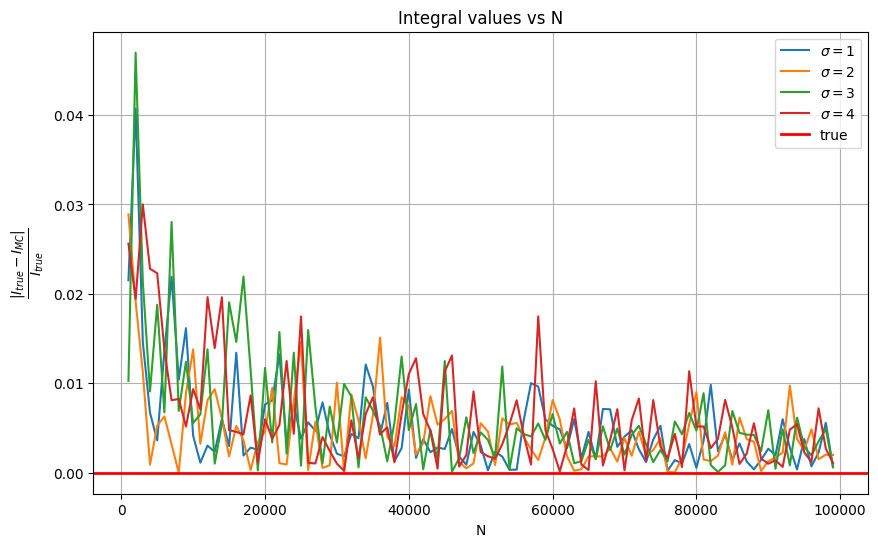

In [4]:
n_values = []
integrals = [[] for _ in range(4)]

for n in range(1000, 100000, 1000):
    for i in range(len(integrals)): 
        f_lambda = lambda x: f(x, sigmas[i])
        integral_value = np.abs(MonteCarlo_integration(f_lambda, 0, extremes[i], n) - (2 * sigmas[i] ** 4)) / (2 * sigmas[i] ** 4)
        integrals[i].append(integral_value)  
    n_values.append(n)

# Plot dei risultati
plt.figure(figsize=(10, 6))
for i in range(len(integrals)):
    plt.plot(n_values, integrals[i], label=rf"$\sigma = {sigmas[i]}$")
plt.axhline(0, color='red', linewidth=2, label='true')
plt.xlabel("N")
plt.ylabel(r"$\frac{|I_{true} - I_{MC}|}{I_{true}}$", size=14)
plt.title("Integral values vs N")
plt.legend()
plt.grid()

plt.show()  

#### Fit to verify how the algorithm scales
$$
\sigma \propto \frac{1}{\sqrt{N}}
$$
To verify this relation we can plot $\log(|I_{true} - I_{MC}|)$ vs $\log(\frac{1}{N})$.
$$
|I_{true} - I_{MC}|\propto\frac{1}{\sqrt{N}}
$$
$$
\log(|I_{true} - I_{MC}|)\propto\frac{1}{2}\log(\frac{1}{N})
$$
So if we fit the data with a model like: 
$$
y = \alpha x + \beta
$$
and we find $\alpha = \frac{1}{2}$, we have solved the problem.

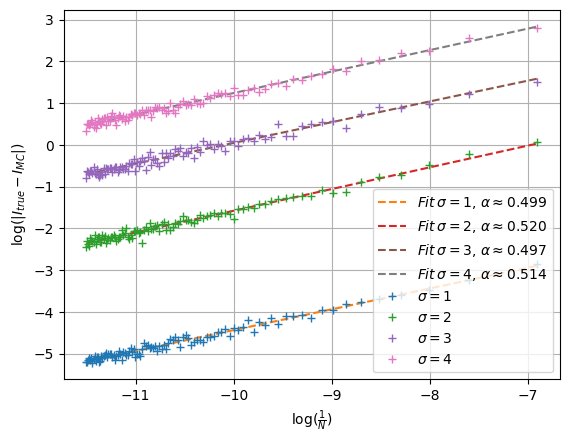

In [5]:
from scipy.optimize import curve_fit

def retta(x, a, b):
    return b + a * x

n_values = []
integral = []

K = 100

for i in range(4):
    n_values_for_sigma = []
    integral_for_sigma = []
        
    for n in range(1000, 100000, 1000):
        f_lambda = lambda x: f(x, sigmas[i])
        sum_value = 0
        for _ in range(K):
            sum_value += np.abs(MonteCarlo_integration(f_lambda, 0, extremes[i], n) - (2 * sigmas[i] ** 4))
        
        integral_for_sigma.append(np.log(sum_value / K)) 
        n_values_for_sigma.append(np.log(1 / n))

    n_values.extend(n_values_for_sigma)
    integral.extend(integral_for_sigma)
    
    c, _ = curve_fit(retta, n_values_for_sigma, integral_for_sigma)
    plt.errorbar(n_values_for_sigma, integral_for_sigma, label=f"$\sigma = {sigmas[i]}$", linestyle="None", marker="+")

    t = np.linspace(np.min(n_values_for_sigma), np.max(n_values_for_sigma), 1000)
    plt.plot(t, (c[1]) + t * c[0], label=rf"$Fit\,\sigma = {sigmas[i]}$, $ \alpha \approx $" + f"${c[0]:.3f}$", linestyle='--')

plt.legend()

plt.xlabel(r"$\log(\frac{1}{N})$")
plt.ylabel(r"$\log(|I_{true} - I_{MC}|)$")  

plt.grid(True)
plt.show()

## Monte Carlo - Importance sampling
The idea is to use a more appropriate distribution function to generate the random numbers. 
$$
\int_a^b \,dx\, f(x) = \int_a^b \,dx\, \frac{f(x)}{g(x)}g(x) 
$$
$$
\int_a^x \,dt\, g(t) = G(x)
$$
$$
\int_a^b \,dG(x)\, \frac{f(x)}{g(x)} = \int_{G(a)}^{G(b)} \,dz\, \frac{f(G^{-1}(z))}{g(G^{-1}(z))} 

For the integral that we want to calculate we can search a solution chosing $g(x) = x e^{-\frac{x^2}{2\sigma^2}}$.
$$
G(x) = \int_0^x \,dt\, t e^{-\frac{t^2}{2\sigma^2}} = -2\sigma^2 e^{-\frac{t^2}{2\sigma^2}}\bigg|_0^x = 2\sigma^2\bigg(1 - e^{-\frac{x^2}{2\sigma^2}}\bigg)
$$
$$
G(0) = 0 \,\,\,\,\, G(\infty) = 2\sigma^2
$$
$$
G^{-1}(x) = \sqrt{2\sigma^2\log\bigg(\frac{1}{1 - \frac{x}{2\sigma^2}}\bigg)}
$$
$$
\frac{f(x)}{g(x)} = x^2
$$
So the integral became: 
$$
\int_0^{2\sigma^2}\,dx\, 2\sigma^2\log\bigg(\frac{2\sigma^2}{2\sigma^2 - x}\bigg)
$$
We can now apply the Monte Carlo algorithm to this new integral to find the value. 


In [ ]:
def g(x, sigma):
    return x * np.exp(-x**2 / (2 * sigma**2))

def G(x, sigma):
    return 1 - np.exp(-x**2 / (2 * sigma**2))

def inverse_G(x, sigma):
    return np.sqrt(-2 * sigma**2 * np.log(1 - x))

i = 3
sigma = sigmas[i]
print(MonteCarlo_integration(lambda x: f(x, sigma)/g(x, sigma), G(0, sigma), G(extremes[i], sigma), 10000), 2 * sigma ** 4)


0.3339250270753166 512
